In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
r = 0.25 #cm
pitch = 0.625 #cm

N0 = 2e22 #cm^-2
N1 = 3e23 #cm^-2
s_p1 = 20 # barns

## POINT A

$$ l = \frac{4S}{P} = \frac{4\pi r^2}{2\pi r} = 2r$$
$$ \sigma_e = \frac{1}{l N_0} = \frac{1}{2rN_0}$$

In [3]:
l = 2*r
s_e = (1/(l*N0))*1e24
print("Sigma_e: {:.0f}b".format(s_e))

Sigma_e: 100b


The mean free path of a neutron in the moderator is:
$$ mfp = \frac{1}{\Sigma_{t1}} = \frac{1}{N_1\sigma_{p1}} = \frac{1}{6} cm$$

Therefore the radius of the pincell expressed in mean free paths is $r = 1.5 $mfp, the pitch/r ratio is 2.5, therefore the Dancoff factor can be extracted from the plot to be $C=0.2$

In [4]:
C = 0.2

We apply the following formula for the Carlvik two-term approximation with the Dancoff correction:

$$ A = \frac{1-C}{C} $$
$$ \alpha_{1,2} = \frac{(5A-6) \mp \sqrt{A^2 + 36A+ 36}}{2(A+1)}$$

and 

$$ \sigma_{b1} = \frac{\sum_{i\in fuel} \lambda_i N_i \sigma_{pi}}{N0} + \alpha_1\sigma_e $$
$$ \sigma_{b2} = \frac{\sum_{i\in fuel} \lambda_i N_i \sigma_{pi}}{N0} + \alpha_2\sigma_e $$

where we sum over all the background nuclides of the fuel to compute the dilution. In our case the only nuclide is the fuel is X, which implies:

$$ \sigma_{b1} = \alpha_1\sigma_e $$
$$ \sigma_{b2} = \alpha_2\sigma_e $$

In [5]:
A = (1-C)/C
alpha_1 = ((5*A+6) - np.sqrt(A**2 + 36*A + 36))/(2*(A+1))
alpha_2 = ((5*A+6) + np.sqrt(A**2 + 36*A + 36))/(2*(A+1))

s_b1 = alpha_1*s_e
s_b2 = alpha_2*s_e

print("Sigma_b1: {:.0f}b".format(s_b1))
print("Sigma_b1: {:.0f}b".format(s_b2))

Sigma_b1: 120b
Sigma_b1: 400b


.

## POINT B

In [6]:
def flux_NR(energies, xs_p0, xs_d, xs_t0):
    flux = (xs_p0 + xs_d)/(np.multiply(energies, xs_t0+xs_d))
    return flux

def flux_integral(energies, flux):
    return np.trapz(flux, energies)

def resonance_integral(energies, flux, sigma):
    return np.trapz(np.multiply(flux, sigma), energies)

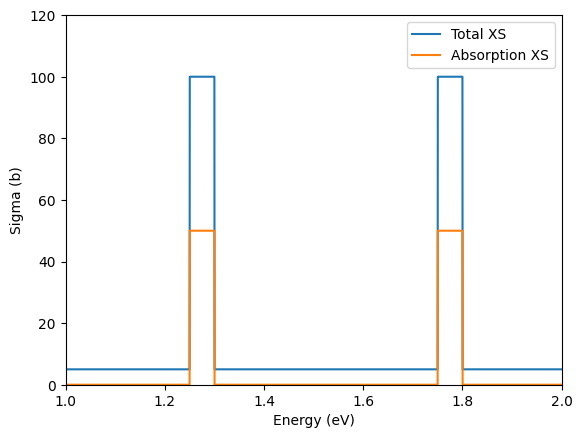

In [7]:
# DEFINE THE CROSS SECTIONS IN ENERGY SPACE

energies = np.linspace(1,2,5000)

s_p0 = 5

# TOTAL RESONANT 
s_t0_pot = np.full_like(energies, 5)
resonance_logic =  np.logical_or(np.logical_and(energies>=1.25, energies<=1.3), np.logical_and(energies>=1.75, energies<=1.8))
s_t0_res = np.full_like(energies, 95)*resonance_logic
s_t0 = s_t0_pot+s_t0_res

# ABSORPTION RESONANT
s_a0_pot = np.full_like(energies, 0)
resonance_logic =  np.logical_or(np.logical_and(energies>=1.25, energies<=1.3), np.logical_and(energies>=1.75, energies<=1.8))
s_a0_res = np.full_like(energies, 50)*resonance_logic
s_a0 = s_a0_pot+s_a0_res


plt.plot(energies, s_t0, label="Total XS")
plt.plot(energies, s_a0, label="Absorption XS")
plt.xlabel("Energy (eV)")
plt.ylabel("Sigma (b)")
plt.xlim(1,2)
plt.ylim(0,120)
plt.legend()
plt.show()

We can apply the Narrow Resonance (NR) model to find the flux:

$$ \phi(E) = \frac{1}{E}\frac{\sigma_{p0} + \sigma_b}{\sigma_{t0} + \sigma_b} $$

and the basic definitions for flux integral (FI) and resonance integral (RI):

$$ FI = \int_{E_1}^{E_2} \phi(E) dE$$
$$ RI_x = \int_{E_1}^{E_2} \phi(E) \sigma_x(E)dE$$

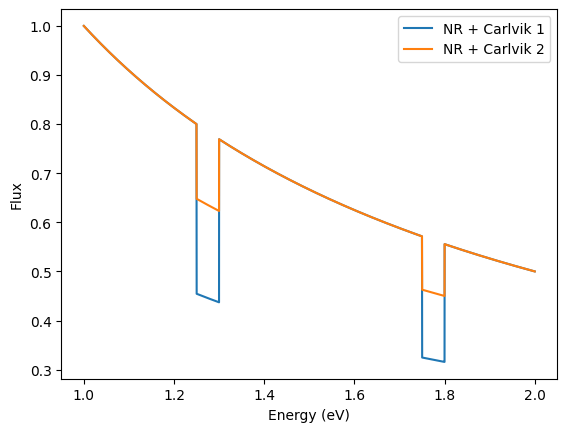

In [8]:
flux_NR1 = flux_NR(energies, s_p0, s_b1, s_t0)
flux_NR2 = flux_NR(energies, s_p0, s_b2, s_t0)

FI1 = flux_integral(energies, flux_NR1)
FI2 = flux_integral(energies, flux_NR2)

RI1 = resonance_integral(energies, flux_NR1, s_t0)
RI2 = resonance_integral(energies, flux_NR2, s_t0)

plt.plot(energies, flux_NR1, label='NR + Carlvik 1')
plt.plot(energies, flux_NR2, label='NR + Carlvik 2')
plt.xlabel("Energy (eV)")
plt.ylabel("Flux")
plt.legend()
plt.show()

Because of the Dancoff correction:

$$ \beta = \frac{\frac{4A+6}{A+1} - \alpha_1}{\alpha_2 - \alpha_1} $$

and finally the group cross section for reaction x is:

$$ \sigma = \frac{\beta RI_1 + (1-\beta)RI_2}{\beta FI_1 + (1-\beta)FI_2}$$

In [9]:
# Carlvik + Dancoff
beta = ((4*A+6)/(A+1)- alpha_1)/(alpha_2-alpha_1)

group_xs_t = (beta*RI1 + (1-beta)*RI2)/(beta*FI1 + (1-beta)*FI2)

print("The total group cross section for the nuclide X is: {:.1f}b".format(group_xs_t))

The total group cross section for the nuclide X is: 10.2b


## POINT C

In [10]:
flux_NR1 = flux_NR(energies, s_p0, s_b1, s_t0)
flux_NR2 = flux_NR(energies, s_p0, s_b2, s_t0)

FI1 = flux_integral(energies, flux_NR1)
FI2 = flux_integral(energies, flux_NR2)

RI1 = resonance_integral(energies, flux_NR1, s_a0)
RI2 = resonance_integral(energies, flux_NR2, s_a0)

In [11]:
# Carlvik + Dancoff

group_xs_a = (beta*RI1 + (1-beta)*RI2)/(beta*FI1 + (1-beta)*FI2)
print("The absorption group cross section for the nuclide X is: {:.1f}b".format(group_xs_a))

The absorption group cross section for the nuclide X is: 2.7b


.

## POINT D

Using the Carlvik approximation with the Dancoff correction the probability for fuel-to-mod is:

$$ P_{f\rightarrow m} = \beta\frac{\alpha_1}{\Sigma_{t,f}l + \alpha_1} + (1-\beta)\frac{\alpha_2}{\Sigma_{t,f}l + \alpha_2} $$

Then it's immediate to compute the fuel-to-fuel probability given the 2 region problem:

$$ P_{f\rightarrow f} = 1 - P_{f\rightarrow m} $$

In our case $\Sigma_{t,f} = N_0\sigma_{t,f}$ where $\sigma_{t,f}$ is the group xs computed in point B.


In [12]:
# Compute XS converting back to cm^2
XS_tf = N0*group_xs_t*1e-24
XS_tm = N1*s_p1*1e-24 

P_fm = beta*alpha_1/(XS_tf*l + alpha_1) +(1-beta)*alpha_2/(XS_tf*l + alpha_2)
P_ff = 1-P_fm

print("The fuel-to-mod probability is: {:.3f}".format(P_fm))
print("The fuel-to-fuel probability is: {:.3f}".format(P_ff))

The fuel-to-mod probability is: 0.914
The fuel-to-fuel probability is: 0.086


.

.

## POINT E

The effects of the modified density are linear up to the flux computation through the Narrow Resonance model. In fact by doubling the density both the background cross sections $\sigma_{b1}$ and $\sigma_{b2}$ halve but then the flux changes according to:

$$ \phi_{NR}(E) = \frac{1}{E}\frac{\sigma_{p0} + \sigma_b}{\sigma_{t0} + \sigma_b} $$

Then we have to repeat the whole process above for each density.

In [13]:
def reaction_rate_densities_fuel(N0, C, r=0.25, verbose=False):
    pitch = 0.625 #cm

    N1 = 3e23 #cm^-2
    s_p1 = 20 # barns
    
    l = 2*r
    s_e = (1/(l*N0))*1e24
    if verbose:
        print("Sigma_e: {:.0f}b".format(s_e))

    A = (1-C)/C
    alpha_1 = ((5*A+6) - np.sqrt(A**2 + 36*A + 36))/(2*(A+1))
    alpha_2 = ((5*A+6) + np.sqrt(A**2 + 36*A + 36))/(2*(A+1))

    s_b1 = alpha_1*s_e
    s_b2 = alpha_2*s_e

    if verbose:
        print("Sigma_b1: {:.0f}b".format(s_b1))
        print("Sigma_b1: {:.0f}b".format(s_b2))


    flux_NR1 = flux_NR(energies, s_p0, s_b1, s_t0)
    flux_NR2 = flux_NR(energies, s_p0, s_b2, s_t0)

    FI1 = flux_integral(energies, flux_NR1)
    FI2 = flux_integral(energies, flux_NR2)
    
    RI1 = resonance_integral(energies, flux_NR1, s_t0)
    RI2 = resonance_integral(energies, flux_NR2, s_t0)
    
    beta = ((4*A+6)/(A+1)- alpha_1)/(alpha_2-alpha_1)
    
    rr_total = (beta*RI1 + (1-beta)*RI2)*N0*1e-24 # 1/cm3/s
    
    group_xs_t = (beta*RI1 + (1-beta)*RI2)/(beta*FI1 + (1-beta)*FI2)

    if verbose:
        print("The total group cross section for the nuclide X is: {:.1f}b".format(group_xs_t))
    

    RI1 = resonance_integral(energies, flux_NR1, s_a0)
    RI2 = resonance_integral(energies, flux_NR2, s_a0)
    
    rr_abso = (beta*RI1 + (1-beta)*RI2)*N0*1e-24 # 1/cm3/s
    
    group_xs_a = (beta*RI1 + (1-beta)*RI2)/(beta*FI1 + (1-beta)*FI2)
    
    if verbose:
        print("The absorption group cross section for the nuclide X is: {:.1f}b".format(group_xs_a))
    
    # Compute XS converting back to cm^2
    XS_tf = N0*group_xs_t*1e-24
    XS_tm = N1*s_p1*1e-24 

    P_fm = beta*alpha_1/(XS_tf*l + alpha_1) +(1-beta)*alpha_2/(XS_tf*l + alpha_2)
    P_ff = 1-P_fm

    if verbose:
        print("The fuel-to-mod probability is: {:.3f}".format(P_fm))
        print("The fuel-to-fuel probability is: {:.3f}".format(P_ff))
    
    return [rr_total, rr_abso]

In [14]:
NN00 = [2e22, 4e22]

rrdd_fuel = []

for N0 in NN00:
    print("============================== N0 = {:.0e} ===========================".format(N0))
    tot, abso = reaction_rate_densities_fuel(N0, C=0.2, verbose=True)
    rrdd_fuel.append([tot, abso])
    print("Total Reaction Rate Density in fuel: {:.2f} 1/cm3/s".format(tot))
    print("Absorption Reaction Rate Density in fuel: {:.2f} 1/cm3/s".format(abso))
   

============================== N0 = 2e+22 ===========================
Sigma_e: 100b
Sigma_b1: 120b
Sigma_b1: 400b
The total group cross section for the nuclide X is: 10.2b
The absorption group cross section for the nuclide X is: 2.7b
The fuel-to-mod probability is: 0.914
The fuel-to-fuel probability is: 0.086
Total Reaction Rate Density in fuel: 0.13 1/cm3/s
Absorption Reaction Rate Density in fuel: 0.04 1/cm3/s
============================== N0 = 4e+22 ===========================
Sigma_e: 50b
Sigma_b1: 60b
Sigma_b1: 200b
The total group cross section for the nuclide X is: 8.6b
The absorption group cross section for the nuclide X is: 1.9b
The fuel-to-mod probability is: 0.862
The fuel-to-fuel probability is: 0.138
Total Reaction Rate Density in fuel: 0.22 1/cm3/s
Absorption Reaction Rate Density in fuel: 0.05 1/cm3/s


We can then compute the macroscopic reaction rate in the fuel just by multiplying by the fuel (we will obtain the results normalized by the depth of our geometry).

In [15]:
V_f = np.pi*r**2
rr_fuel = np.array(rrdd_fuel)*V_f # 1/cm/s

In [16]:
print("\n\n===================================== N0 = {:.0e} at/cm3 ==================================\n".format(NN00[0]))
print("Total reaction rate in fuel:         {:.4f} 1/cm/s".format(rr_fuel[0][0]))
print("Absorption reaction rate in fuel:    {:.4f} 1/cm/s    ({:.1f}% of total)".format(rr_fuel[0][1], 100*rr_fuel[0][1]/rr_fuel[0][0]))

print("\n\n===================================== N0 = {:.0e} at/cm3 ==================================\n".format(NN00[1]))
print("Total reaction rate in fuel:         {:.4f} 1/cm/s".format(rr_fuel[1][0], 100*rr_fuel[1][0]/rr_fuel[1][0]))
print("Absorption reaction rate in fuel:    {:.4f} 1/cm/s    ({:.1f}% of total)".format(rr_fuel[1][1], 100*rr_fuel[1][1]/rr_fuel[1][0]))

print("\n\n=================================== RATIOS (after/before) ================================\n".format(NN00[1]))
print("Total reaction rate in fuel:         {:.3f}".format(rr_fuel[1][0]/rr_fuel[0][0]))
print("Absorption reaction rate in fuel:    {:.3f}".format(rr_fuel[1][1]/rr_fuel[0][1]))





===================================== N0 = 2e+22 at/cm3 ==================================

Total reaction rate in fuel:         0.0264 1/cm/s
Absorption reaction rate in fuel:    0.0071 1/cm/s    (26.7% of total)


===================================== N0 = 4e+22 at/cm3 ==================================

Total reaction rate in fuel:         0.0440 1/cm/s
Absorption reaction rate in fuel:    0.0097 1/cm/s    (22.1% of total)


=================================== RATIOS (after/before) ================================

Total reaction rate in fuel:         1.665
Absorption reaction rate in fuel:    1.374


.

.

## POINT F

The simplest way of increasing the absorption reaction rate is to increase the size of the fuel rod relative fixing the ratio between it and the lattice pitch. As a first approximation we can fix the Dancoff correction factor while doing the calculation (from Figure 2 it appears that increasing the radius of the rod slightly will not change C massively).

In [17]:
radii = np.linspace(0.05,0.4, 100)
rr_abso = []

for r in radii:
    t, a = reaction_rate_densities_fuel(2e22, C=.2, r=r)
    rr_abso.append(a*np.pi*r**2)


ref_abso = reaction_rate_densities_fuel(2e22, C=.2)
ref_abso = ref_abso[1]*V_f
target_abso = reaction_rate_densities_fuel(4e22, C=.2)
target_abso = target_abso[1]*V_f

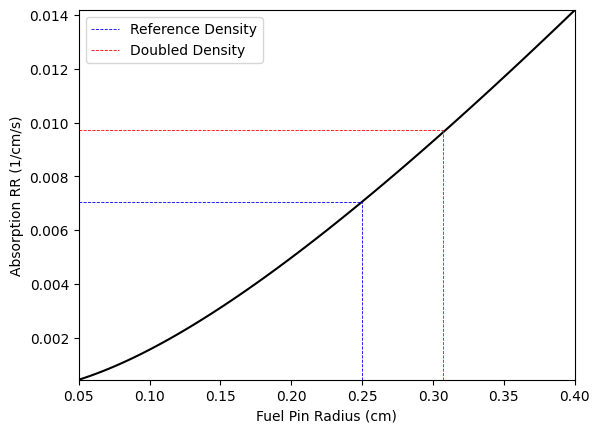

In [18]:
plt.plot(radii, rr_abso, color='k')

plt.hlines([ref_abso], 0,.25, color='blue', linestyle='--', linewidth=.6, label='Reference Density')
plt.vlines([0.25], min(rr_abso), ref_abso, color='blue', linestyle='--', linewidth=.6)

plt.hlines([target_abso], 0,.307, color='red', linestyle='--', linewidth=.6, label='Doubled Density')
plt.vlines([0.307], min(rr_abso), target_abso, color='red', linestyle='--', linewidth=.6)

plt.xlim(.05,.4)
plt.ylim(min(rr_abso), max(rr_abso))

plt.ylabel("Absorption RR (1/cm/s)")
plt.xlabel("Fuel Pin Radius (cm)")

plt.legend()

As we can see from the figure above a radius of about 0.31 cm will yield the desired reaction rate.
Tweaking the value and considering correct Dancoff correction factors a radius of 0.3 cm will yield the right absorption reaction rate:

In [19]:
t, a = reaction_rate_densities_fuel(2e22, C=.14, r=.3)
print("Target RR: {:.4f} 1/cm/s".format(target_abso))
print("Bigger fuel rod RR: {:.4f} 1/cm/s".format(a*np.pi*.3**2))

Target RR: 0.0097 1/cm/s
Bigger fuel rod RR: 0.0097 1/cm/s


So the final configuration is:
 - Fuel Pin Radius: 0.3 cm
 - Lattice Pitch: 0.75 cm

.

.

## POINT G

$$ l = \frac{4S}{P} = \frac{4\pi r^2}{2\pi r} = 2r$$
$$ \sigma_e = \frac{1}{l N_0} = \frac{1}{2rN_0}$$

In [20]:
r = 0.25 #cm
pitch = 0.625 #cm

N0 = 2e22 #cm^-2
N1 = 1.5e23 #cm^-2
s_p1 = 3.4 # barns

l = 2*r
s_e = (1/(l*N0))*1e24
print("Sigma_e: {:.0f}b".format(s_e))

Sigma_e: 100b


The lattice size / fuel pin radius ratio stays the same (2.5) while the measure of the radius in mean free paths in the moderator changes from 1.5 to 0.1275. Therefore the Dancoff correction factor increases from 0.2 to about 0.85.

In [28]:
C = 0.85

We apply the same formulas as before:

$$ A = \frac{1-C}{C} $$
$$ \alpha_{1,2} = \frac{(5A-6) \mp \sqrt{A^2 + 36A+ 36}}{2(A+1)}$$

and 

$$ \sigma_{b1} = \frac{\sum_{i\in fuel} \lambda_i N_i \sigma_{pi}}{N0} + \alpha_1\sigma_e $$
$$ \sigma_{b2} = \frac{\sum_{i\in fuel} \lambda_i N_i \sigma_{pi}}{N0} + \alpha_2\sigma_e $$

The only nuclide is the fuel is X, which implies:

$$ \sigma_{b1} = \alpha_1\sigma_e $$
$$ \sigma_{b2} = \alpha_2\sigma_e $$

In [29]:
A = (1-C)/C
alpha_1 = ((5*A+6) - np.sqrt(A**2 + 36*A + 36))/(2*(A+1))
alpha_2 = ((5*A+6) + np.sqrt(A**2 + 36*A + 36))/(2*(A+1))

s_b1 = alpha_1*s_e
s_b2 = alpha_2*s_e

print("Sigma_b1: {:.0f}b".format(s_b1))
print("Sigma_b1: {:.0f}b".format(s_b2))

Sigma_b1: 16b
Sigma_b1: 569b


.

.

## POINT H

Fixing the atomic density of nuclide X to the reference value of $2\cdot10^{22}$ and assuming no absorption by C we can use the equivalent cross section and Dancoff correction factor computed in point G.

The presence of C changes the background cross section for the fuel:

$$ \sigma_{b1} = \frac{\lambda_C N_C \sigma_{p,C}}{N_0} + \alpha_1\sigma_e $$
$$ \sigma_{b2} = \frac{\lambda_C N_C \sigma_{p,C}}{N_0} + \alpha_2\sigma_e $$

Given the fact that we're using the Narrow Resonance model we can set $\lambda_C = 1$

In [44]:
def absorption_XC(NC, verbose=False):

    r = 0.25 #cm
    pitch = 0.625 #cm

    N0 = 2e22 #cm^-2
    N1 = 1.5e23 #cm^-2
    s_p1 = 3.4 # barns
    s_pc = 4.7 # barns

    l = 2*r
    s_e = (1/(l*N0))*1e24

    if verbose:
        print("Sigma_e:  {:.0f}b".format(s_e))

    C = 0.85
    A = (1-C)/C
    alpha_1 = ((5*A+6) - np.sqrt(A**2 + 36*A + 36))/(2*(A+1))
    alpha_2 = ((5*A+6) + np.sqrt(A**2 + 36*A + 36))/(2*(A+1))

    s_b1 = NC*s_pc/N0 + alpha_1*s_e
    s_b2 = NC*s_pc/N0 + alpha_2*s_e

    if verbose:
        print("Sigma_b1: {:.0f}b".format(s_b1))
        print("Sigma_b1: {:.0f}b".format(s_b2))

    flux_NR1 = flux_NR(energies, s_p0, s_b1, s_t0)
    flux_NR2 = flux_NR(energies, s_p0, s_b2, s_t0)

    FI1 = flux_integral(energies, flux_NR1)
    FI2 = flux_integral(energies, flux_NR2)
    
    RI1 = resonance_integral(energies, flux_NR1, s_t0)
    RI2 = resonance_integral(energies, flux_NR2, s_t0)
    
    beta = ((4*A+6)/(A+1)- alpha_1)/(alpha_2-alpha_1)
    
    rr_total = (beta*RI1 + (1-beta)*RI2)*N0*1e-24 # 1/cm3/s
    
    group_xs_t = (beta*RI1 + (1-beta)*RI2)/(beta*FI1 + (1-beta)*FI2)

    if verbose:
        print("The total group cross section for the nuclide X is: {:.1f}b".format(group_xs_t))
    

    RI1 = resonance_integral(energies, flux_NR1, s_a0)
    RI2 = resonance_integral(energies, flux_NR2, s_a0)
    
    rr_abso = (beta*RI1 + (1-beta)*RI2)*N0*1e-24 # 1/cm3/s
    
    group_xs_a = (beta*RI1 + (1-beta)*RI2)/(beta*FI1 + (1-beta)*FI2)
    
    if verbose:
        print("The absorption group cross section for the nuclide X is: {:.1f}b".format(group_xs_a))
    
    # Compute XS converting back to cm^2
    XS_tf = N0*group_xs_t*1e-24
    XS_tm = N1*s_p1*1e-24 

    P_fm = beta*alpha_1/(XS_tf*l + alpha_1) +(1-beta)*alpha_2/(XS_tf*l + alpha_2)
    P_ff = 1-P_fm

    if verbose:
        print("The fuel-to-mod probability is: {:.3f}".format(P_fm))
        print("The fuel-to-fuel probability is: {:.3f}".format(P_ff))
    
    return rr_abso

In [45]:
NNCC = np.linspace(0, 7e23, 100)

rr_abso = []

for NC in NNCC:
    rr_abso.append(absorption_XC(NC, verbose=False)*np.pi*.25**2)
    
target = reaction_rate_densities_fuel(2e22, C=.2)[1]*np.pi*.25**2

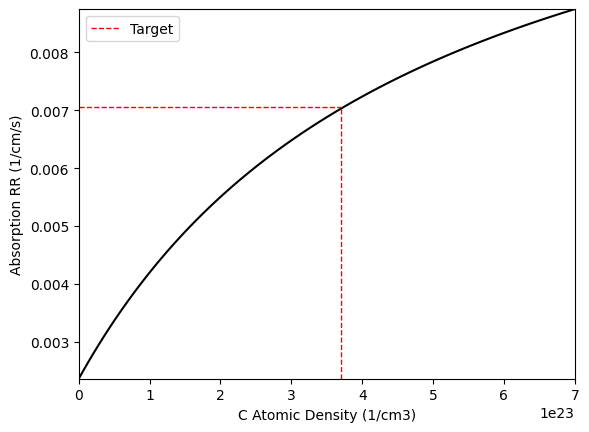

In [48]:
plt.plot(NNCC, rr_abso, color='k')

plt.hlines([target], 0, 3.7e23, color='r', linestyle='--', linewidth=1, label='Target')
plt.vlines([3.7e23], min(rr_abso), ref_abso, color='r', linestyle='--', linewidth=1)

plt.xlim(0,max(NNCC))
plt.ylim(min(rr_abso), max(rr_abso))

plt.ylabel("Absorption RR (1/cm/s)")
plt.xlabel("C Atomic Density (1/cm3)")

plt.legend()

The desired absorption reaction rate can be obtained with a carbon atomic density of $3.7\cdot 10^{23}$ $at/cm^{3}$.

.

.